In [23]:
import numpy as np

# ------------------------------
# 1. Define HMM Components
# ------------------------------

states = ['S1(/h/)', 'S2(/e/)', 'S3(/l/)', 'S4(/o/)']
observations = ['O1', 'O2', 'O3', 'O4']  # acoustic features

# Observation sequence captured by the system
obs_sequence = ['O1', 'O2', 'O3', 'O4']

# Initial probabilities π
pi = np.array([1.0, 0.0, 0.0, 0.0])

# Transition matrix A (Left-to-Right HMM)
A = np.array([
    [0.0, 1.0, 0.0, 0.0],  # S1 -> S2
    [0.0, 0.0, 1.0, 0.0],  # S2 -> S3
    [0.0, 0.0, 0.0, 1.0],  # S3 -> S4
    [0.0, 0.0, 0.0, 1.0],  # S4 -> S4
])

# Emission matrix B
# Each phoneme strongly emits its corresponding observation
high = 0.9
low = (1 - high) / 3
B = np.full((4, 4), low)
for i in range(4):
    B[i, i] = high

# Map observation to index
obs_index = {obs: idx for idx, obs in enumerate(observations)}


In [24]:
# ------------------------------
# 2. Viterbi Implementation
# ------------------------------

T = len(obs_sequence)
N = len(states)

delta = np.zeros((T, N))  # best path probabilities
psi = np.zeros((T, N), dtype=int)  # backpointers

# Initialization
o0 = obs_index[obs_sequence[0]]
for j in range(N):
    delta[0, j] = pi[j] * B[j, o0]
    psi[0, j] = 0

# Recursion
for t in range(1, T):
    ot = obs_index[obs_sequence[t]]
    for j in range(N):
        probs = delta[t-1] * A[:, j] * B[j, ot]
        psi[t, j] = np.argmax(probs)
        delta[t, j] = np.max(probs)

# Termination
best_last_state = np.argmax(delta[T-1])
best_prob = delta[T-1, best_last_state]

# Backtracking
best_path = [best_last_state]
for t in range(T-1, 0, -1):
    best_path.insert(0, psi[t, best_path[0]])

best_states = [states[i] for i in best_path]

In [25]:
print("\n=== VITERBI DECODING RESULT ===\n")
print("Most likely phoneme sequence:")
print(best_states)

print("\nProbability of this sequence:")
print(best_prob)

print("\nDelta Table (Path Probabilities):")
print(delta)

print("\nPsi Table (Backpointers):")
print(psi)

# Convert to actual phoneme symbols
phoneme_map = {
    'S1(/h/)': '/h/',
    'S2(/e/)': '/e/',
    'S3(/l/)': '/l/',
    'S4(/o/)': '/o/'
}

decoded_phonemes = [phoneme_map[s] for s in best_states]

print("\nDecoded phonemes:")
print(decoded_phonemes)


=== VITERBI DECODING RESULT ===

Most likely phoneme sequence:
['S1(/h/)', 'S2(/e/)', 'S3(/l/)', 'S4(/o/)']

Probability of this sequence:
0.6561000000000001

Delta Table (Path Probabilities):
[[0.9    0.     0.     0.    ]
 [0.     0.81   0.     0.    ]
 [0.     0.     0.729  0.    ]
 [0.     0.     0.     0.6561]]

Psi Table (Backpointers):
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 2]]

Decoded phonemes:
['/h/', '/e/', '/l/', '/o/']


In [26]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Audio loaded. Duration: 0.9 seconds


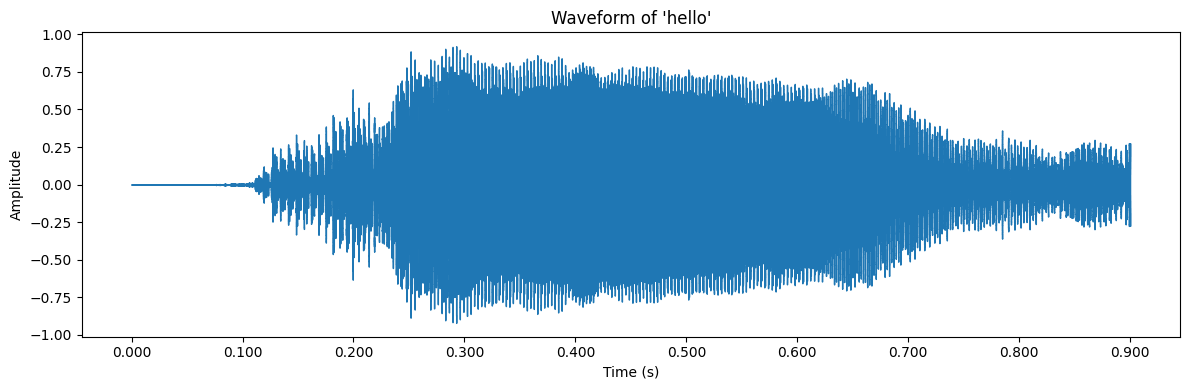

In [27]:
# 1. LOAD AUDIO
# -------------------------------------------------------------
audio_path = "hello.wav"   # <-- replace with your file
y, sr = librosa.load(audio_path, sr=16000,duration=0.9)

print("Audio loaded. Duration:", librosa.get_duration(y=y, sr=sr), "seconds")

# -------------------------------------------------------------
# 2. VISUAL - WAVEFORM
# -------------------------------------------------------------
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of 'hello'")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

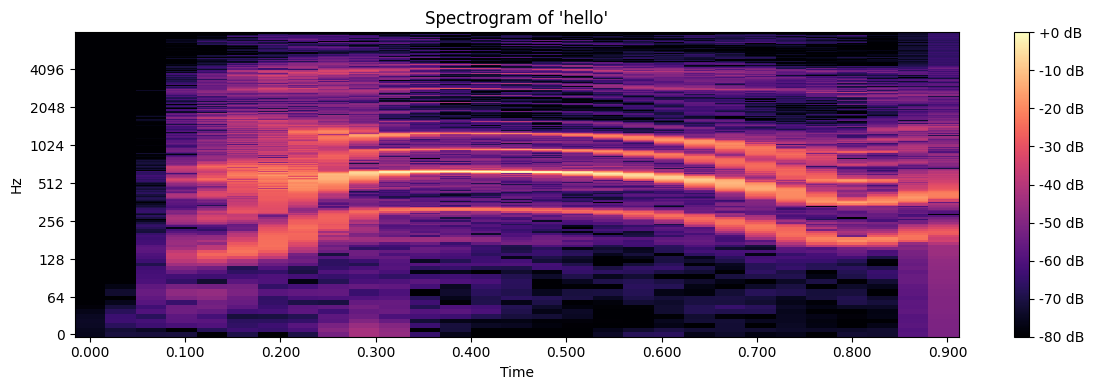

In [28]:
# -------------------------------------------------------------
# 3. VISUAL - SPECTROGRAM
# -------------------------------------------------------------
plt.figure(figsize=(12,4))
spec = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.title("Spectrogram of 'hello'")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [29]:

# -------------------------------------------------------------
# 4. MFCC EXTRACTION
# -------------------------------------------------------------
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfcc_T = mfcc.T
print("MFCC shape:", mfcc_T.shape)

MFCC shape: (29, 13)


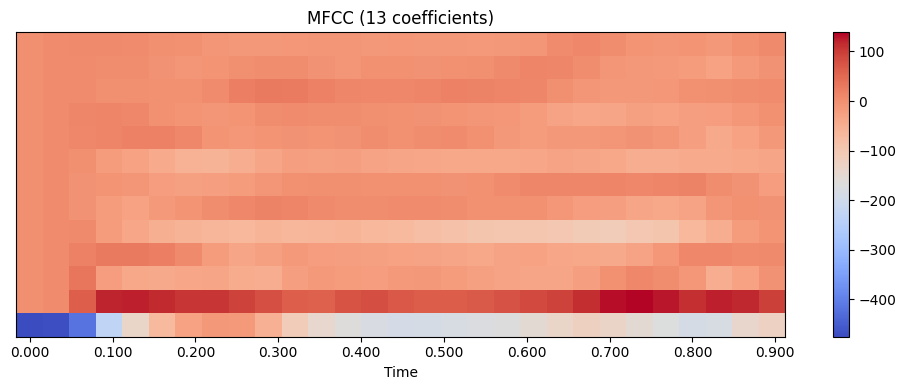

In [30]:
# -------------------------------------------------------------
# VISUAL - MFCC HEATMAP
# -------------------------------------------------------------
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC (13 coefficients)")
plt.tight_layout()
plt.show()

In [31]:

# -------------------------------------------------------------
# 5. CLUSTER MFCC INTO 4 OBSERVATIONS (O1,O2,O3,O4)
# -------------------------------------------------------------
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(mfcc_T)

obs_map = {0:"O1", 1:"O2", 2:"O3", 3:"O4"}
obs_seq = [obs_map[l] for l in labels]

print("Observation sequence:", obs_seq[:50], "...")

Observation sequence: ['O3', 'O3', 'O3', 'O4', 'O4', 'O2', 'O2', 'O2', 'O2', 'O2', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O1', 'O4', 'O4', 'O4', 'O4'] ...


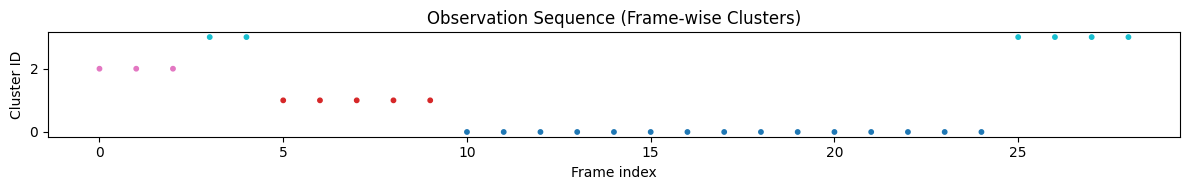

In [32]:
# -------------------------------------------------------------
# VISUAL - OBSERVATION TIMELINE
# -------------------------------------------------------------
plt.figure(figsize=(12,2))
plt.scatter(range(len(labels)), labels, c=labels, cmap="tab10", s=10)
plt.title("Observation Sequence (Frame-wise Clusters)")
plt.xlabel("Frame index")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()

In [33]:
# -------------------------------------------------------------
# 6. DEFINE HMM FOR 'hello'
# -------------------------------------------------------------
states = ["S1(/h/)", "S2(/e/)", "S3(/l/)", "S4(/o/)"]
N = 4

# Initial probabilities
pi = np.array([1,0,0,0])

# Left-to-right transitions
A = np.array([
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1],
    [0,0,0,1]
])

# Emission matrix learned from clusters (simple proportional version)
B = np.zeros((4,4))
total_frames = len(labels)

for s in range(4):
    for o in range(4):
        B[s,o] = np.sum(labels == o) / total_frames

# Normalize rows
B = B / B.sum(axis=1, keepdims=True)

obs_index = {"O1":0, "O2":1, "O3":2, "O4":3}



In [34]:
# -------------------------------------------------------------
# 7. VITERBI ALGORITHM
# -------------------------------------------------------------
T = len(obs_seq)
delta = np.zeros((T,N))
psi = np.zeros((T,N), dtype=int)

# Initialization
delta[0] = pi * B[:, obs_index[obs_seq[0]]]

# Recursion
for t in range(1,T):
    for j in range(N):
        prob = delta[t-1] * A[:,j] * B[j, obs_index[obs_seq[t]]]
        psi[t,j] = np.argmax(prob)
        delta[t,j] = np.max(prob)

# Backtracking
best_last = np.argmax(delta[-1])
path = [best_last]

for t in range(T-1,0,-1):
    path.insert(0, psi[t, path[0]])

decoded_states = [states[p] for p in path]
phoneme_map = {
    "S1(/h/)": "h",
    "S2(/e/)": "e",
    "S3(/l/)": "l",
    "S4(/o/)": "o"
}
decoded_phonemes = [phoneme_map[s] for s in decoded_states]

print("\nDecoded phoneme sequence:")
print(decoded_phonemes[:6])




Decoded phoneme sequence:
['h', 'e', 'l', 'o', 'o', 'o']


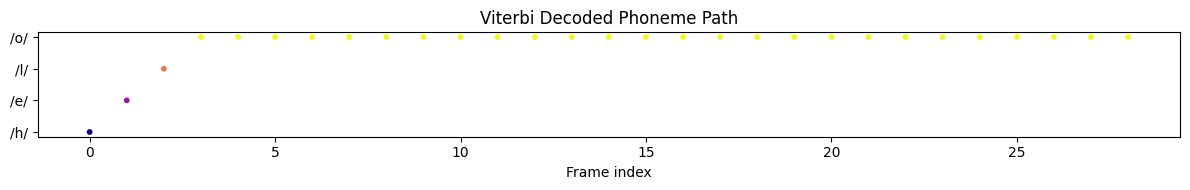

In [35]:
# -------------------------------------------------------------
# 8. VISUAL - VITERBI PATH (STATE TIMELINE)
# -------------------------------------------------------------
state_ids = [path[i] for i in range(len(path))]

plt.figure(figsize=(12,2))
plt.scatter(range(len(state_ids)), state_ids, c=state_ids, cmap="plasma", s=10)
plt.yticks([0,1,2,3], ["/h/","/e/","/l/","/o/"])
plt.xlabel("Frame index")
plt.title("Viterbi Decoded Phoneme Path")
plt.tight_layout()
plt.show()